In [1]:
import os
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from TSB_UAD.utils.visualisation import plotFig
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.models.feature import Window
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.sand import SAND
from TSB_UAD.models.matrix_profile import MatrixProfile
from StreamingDetector import StreamingDetector

Dataset loading and preparation

In [2]:
# Load all time series from the YAHOO domain
public_root = "./data/"
selected_domain = 'YAHOO'
series_list, label_list = [], []
dom_path = os.path.join(public_root, selected_domain)
files = sorted(f for f in os.listdir(dom_path) if f.endswith('.out'))  # Ensure consistent ordering

# Keep only the first i files
i=4
for f in files:
    file_path = os.path.join(dom_path, f)
    df = pd.read_csv(file_path, header=None).dropna()
    data = df.iloc[:, 0].astype(float).to_numpy()
    label = df.iloc[:, 1].astype(int).to_numpy()
    series_list.append(data)
    label_list.append(label)
    i-=1
    if i == 0:  
        break

# Create cumulative time series and labels
series = []
labels = []
for i in range(1, len(series_list) + 1):
    cum_ts = np.concatenate(series_list[:i], axis=0)
    cum_labels = np.concatenate(label_list[:i], axis=0)
    series.append(cum_ts)
    labels.append(cum_labels)


# Create different-normalities time series
norm1_ts = series[0]
norm1_labels = labels[0]
norm2_ts = series[1] if len(series) > 1 else None
norm2_labels = labels[1] if len(labels) > 1 else None
norm3_ts = series[2] if len(series) > 2 else None
norm3_labels = labels[2] if len(labels) > 2 else None
norm4_ts = series[3] if len(series) > 3 else None
norm4_labels = labels[3] if len(labels) > 3 else None

series = [norm1_ts, norm2_ts, norm3_ts, norm4_ts]
labels = [norm1_labels, norm2_labels, norm3_labels, norm4_labels]

In [3]:
# Select normality norm
norm = 2
data = series[norm-1]
label = labels[norm-1]

Offline (Task 4)

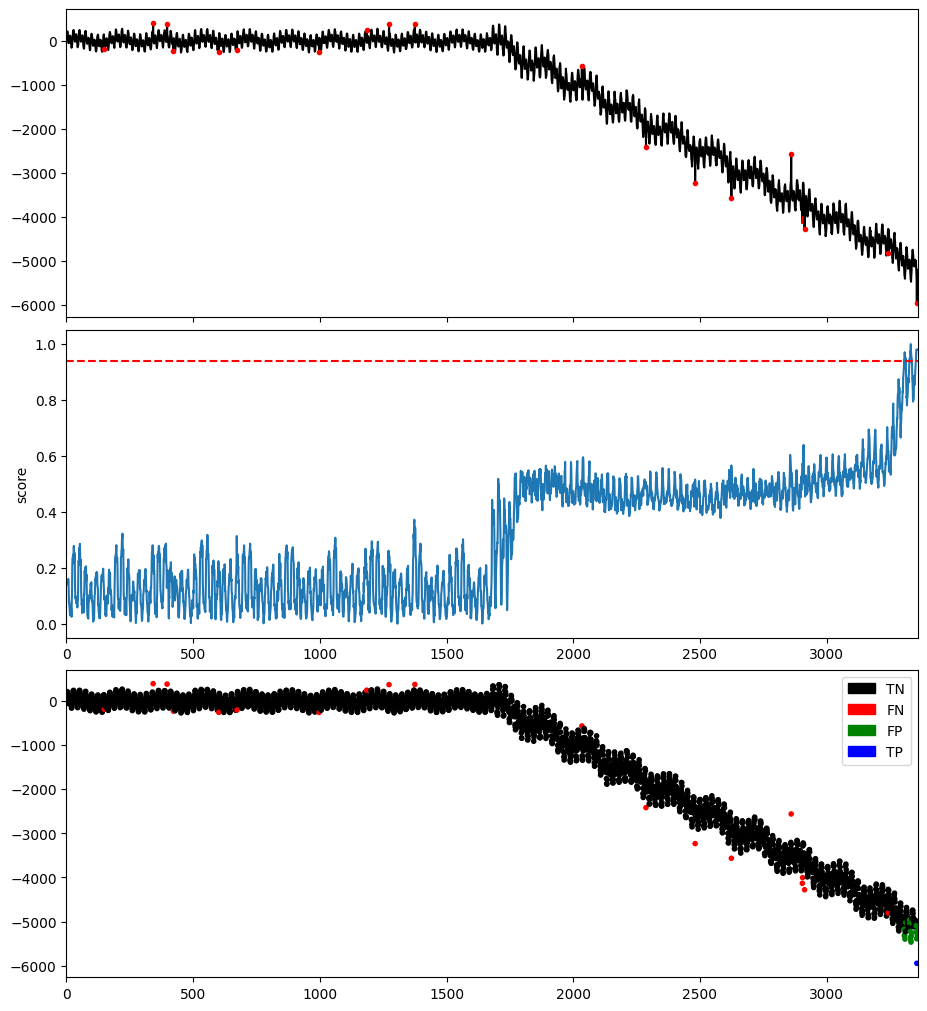

In [4]:
### Offline 1 - IForest
modelName='IForest'
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()
clf = IForest(n_jobs=1)
clf.fit(X_data)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
# plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

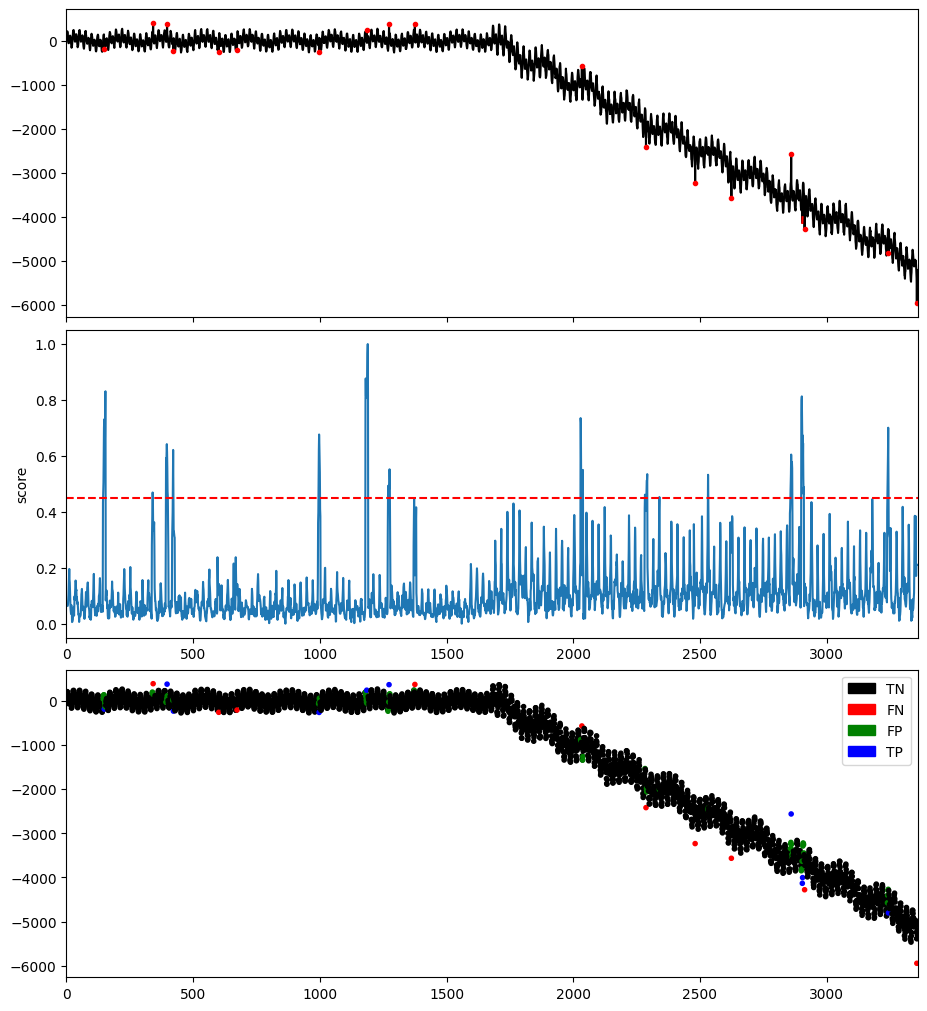

In [5]:
### Offline 2 - MatrixProfile
modelName='MatrixProfile'
slidingWindow = find_length(data)
X_data = data
clf = MatrixProfile(window = slidingWindow)
clf.fit(X_data)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
# plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force

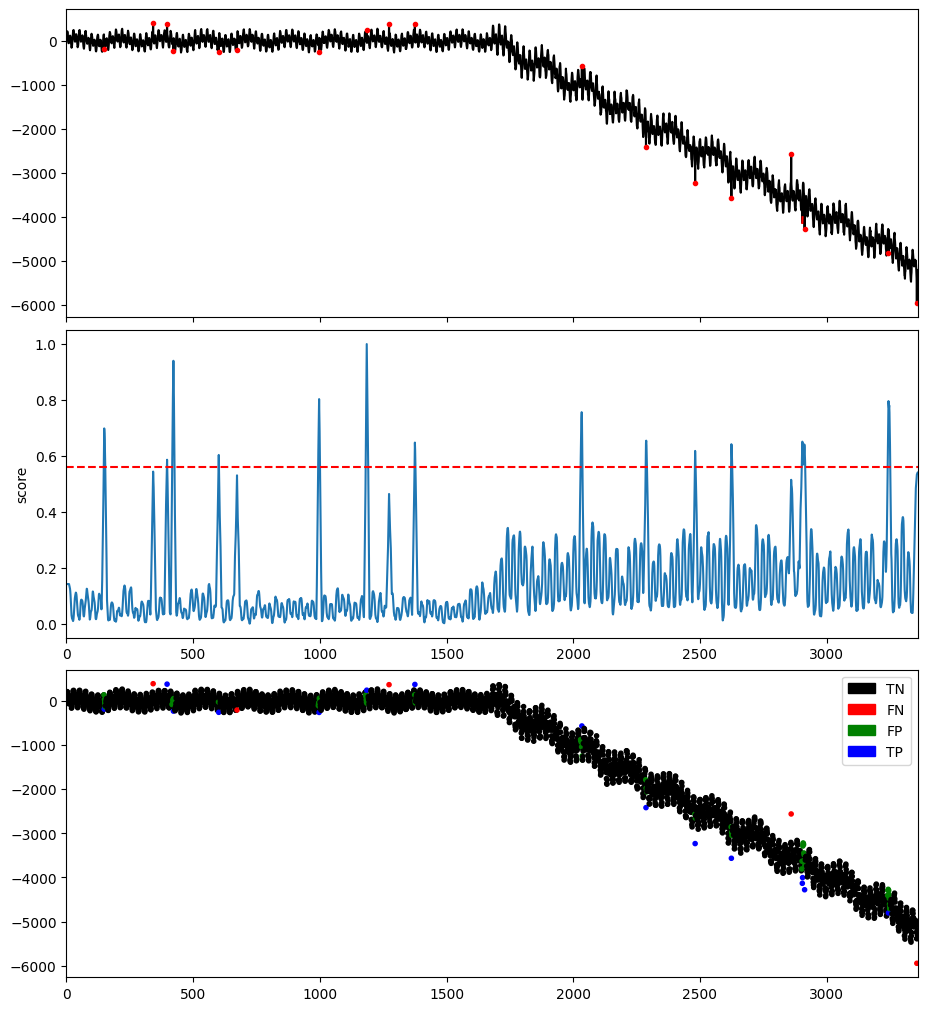

In [6]:
### Offline 3 - SAND
modelName='SAND (offline)'
slidingWindow = find_length(data)
X_data = data
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
clf.fit(X_data,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

Online (Tasks 5 and 6)

In [7]:
## Variant 1 - Batching
batch_size = 500
batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

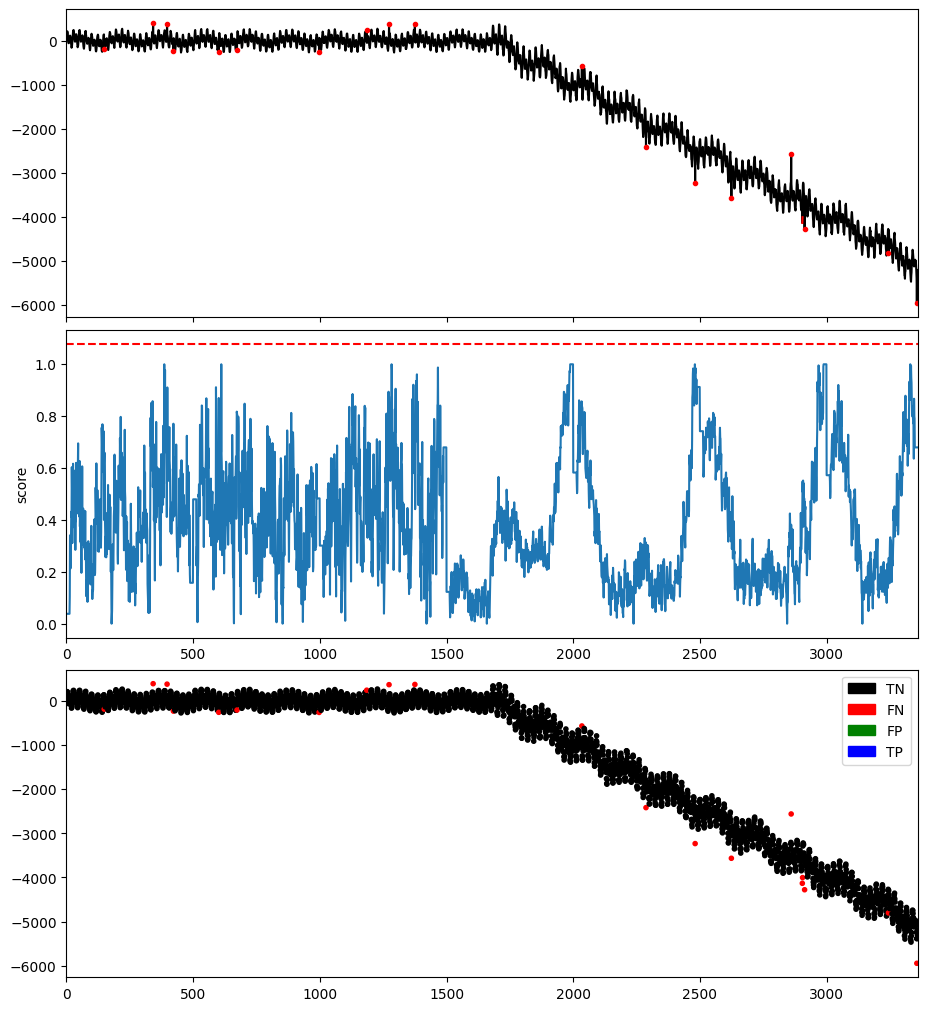

In [8]:
### Batch 1 - IForest
modelName='IForest (batches)'
slidingWindow = find_length(batches[0])
final_scores = None
for i, batch in enumerate(batches):
    X_data = Window(window=slidingWindow).convert(batch).to_numpy()
    clf = IForest(n_jobs=1)
    clf.fit(X_data)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

    scores_for_current_batch = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

    if i == 0:
        final_scores = scores_for_current_batch
    else:
        final_scores = np.concatenate((final_scores, scores_for_current_batch))

    # if i == 0:
    #     final_scores = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    # else:
    #     final_scores = np.concatenate((final_scores, [score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2)))

plotFig(data, label, final_scores, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

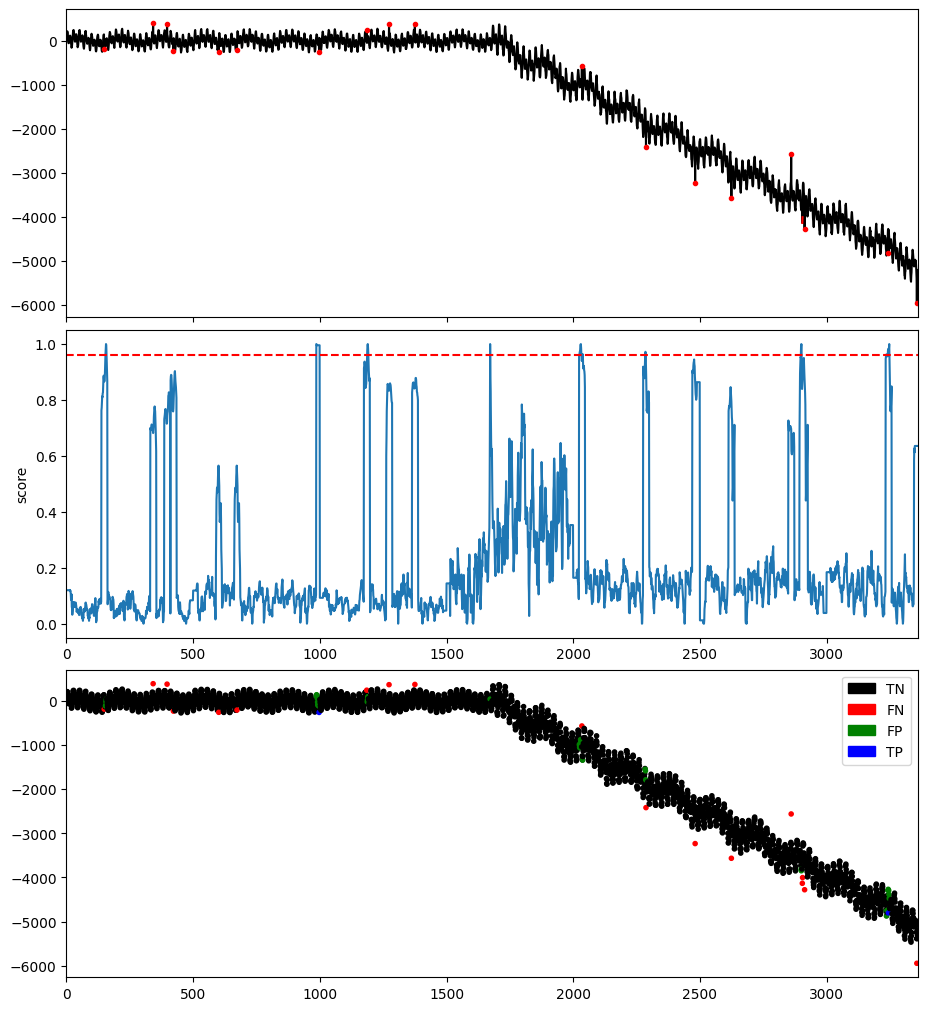

In [9]:
### Batch 2 - MatrixProfile
modelName='MatrixProfile (batches)'
slidingWindow = find_length(batches[0])
final_scores = None
for i, batch in enumerate(batches):
    X_data = batch
    clf = MatrixProfile(window = slidingWindow)
    clf.fit(X_data)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

    scores_for_current_batch = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

    if i == 0:
        final_scores = scores_for_current_batch
    else:
        final_scores = np.concatenate((final_scores, scores_for_current_batch))

    
    # if i == 0:
    #     final_scores = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    # else:
    #     final_scores = np.concatenate((final_scores, [score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2)))

plotFig(data, label, final_scores, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bilpapster/miniconda3/envs/TSB/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force

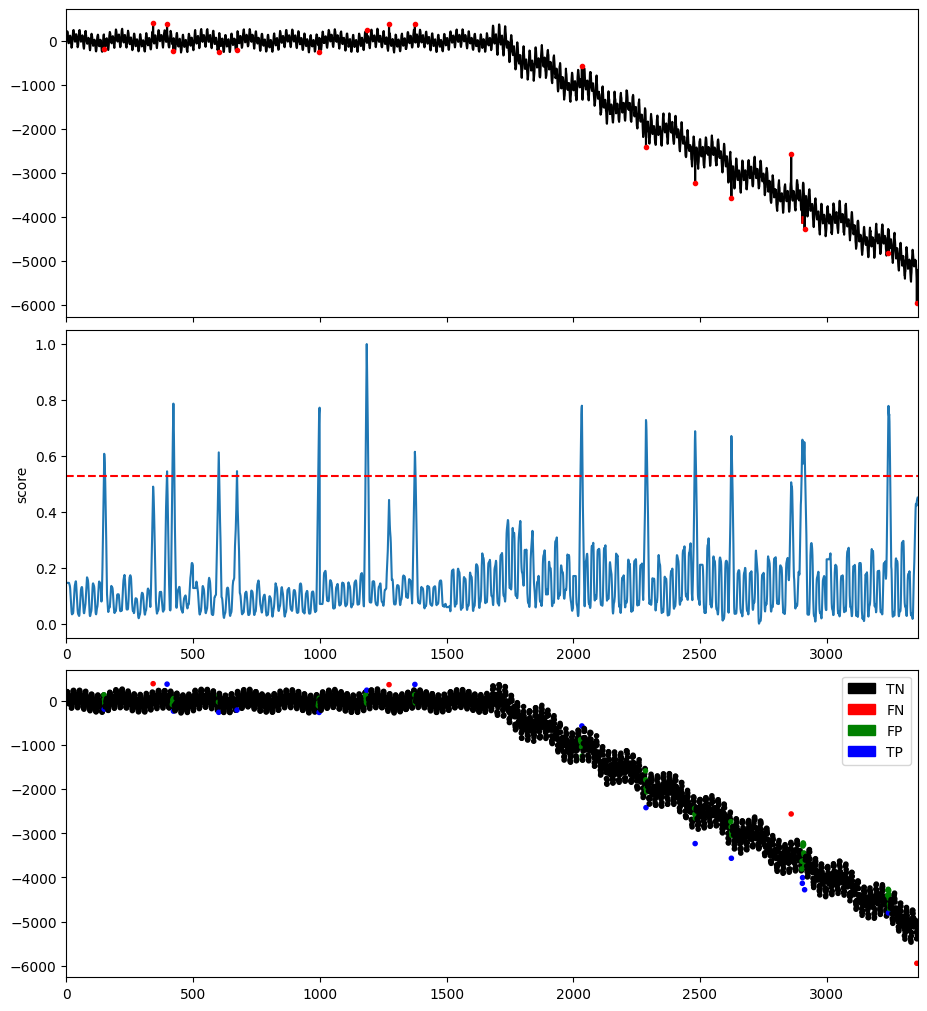

In [10]:
### Batch 3 - SAND
modelName='SAND (online)'
slidingWindow = find_length(data)
X_data = data
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
clf.fit(X_data,online=True,alpha=0.5,init_length=batch_size,batch_size=batch_size,verbose=False,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName="Norm-"+str(norm)+"-"+modelName, modelName=modelName)
plt.show()
#plt.savefig("Norm-"+str(norm)+"-"+modelName, dpi=300, bbox_inches='tight')

In [11]:
# Variant 2 - Streaming

Starting processing of the time series with length 3360 and shape (3360,).

Processing batch 1/10 with 336 data points.
Processing batch with 336 data points and shape (336,).
Extracted 313 subsequences with shape (313, 24).
Extracted 313 subsequences from the batch with shape (313, 24).
Current state shape: 0 x 0.
Combined subsequences with retained state. Total subsequences: 313.
Extracting embeddings for 313 subsequences with shape (313, 23)
Debug mode is set to True. Embeddings are randomly generated.
Fitting anomaly detection on cluster 1 with 71 subsequences
Model fitted. Attempting inference on all subsequences of the current batch.
Shape of all subsequences in the batch: (313, 24)
Fitting anomaly detection on cluster 2 with 83 subsequences
Model fitted. Attempting inference on all subsequences of the current batch.
Shape of all subsequences in the batch: (313, 24)
Fitting anomaly detection on cluster 3 with 78 subsequences
Model fitted. Attempting inference on all subsequences 

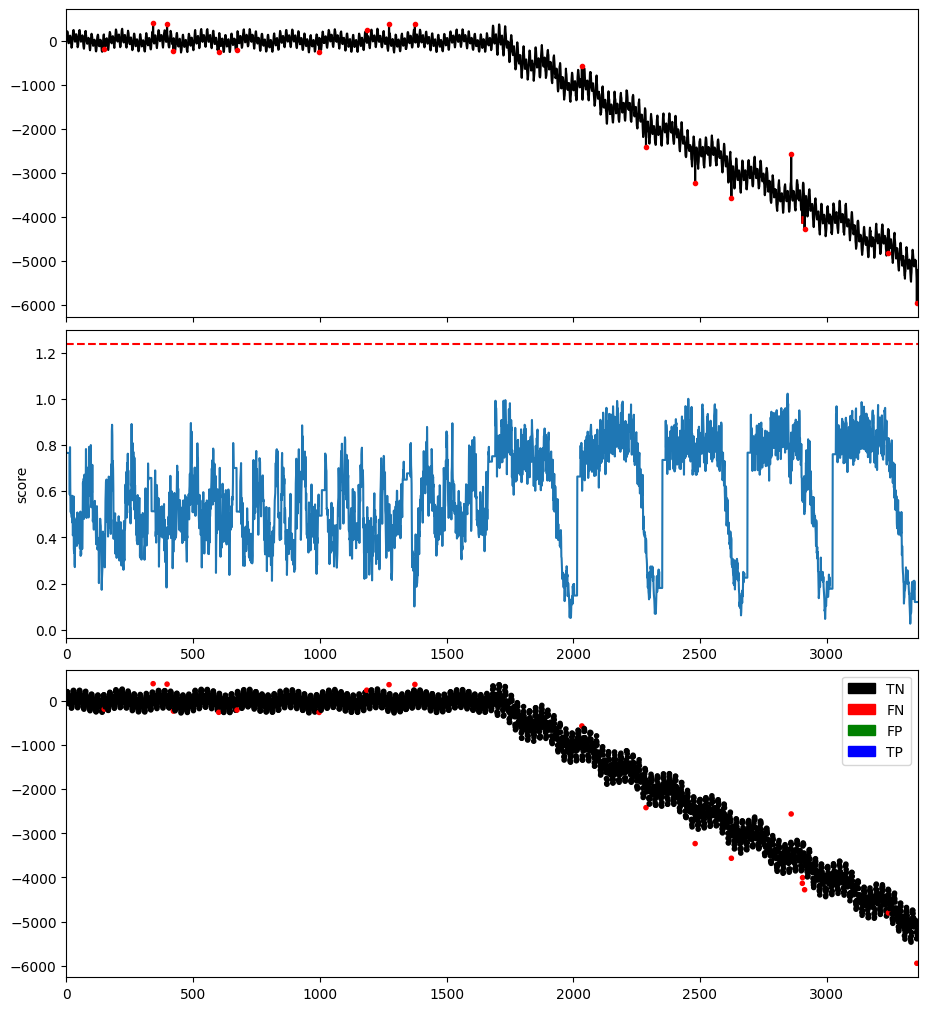

In [12]:
### Online 1 - IForest
sb_if = StreamingDetector(
batch_frac=0.1,
    overlap=1,
    n_clusters=4,
    model="iforest",
    state_size=None,       
    tabpfn_device='cpu'
)
scores = sb_if.process(data)
sliding = find_length(data)
plotFig(data, label, scores, sliding, fileName='Stream_IForest', modelName='StreamIForest')
plt.show()
#plt.savefig('Stream_IForest.png', dpi=300, bbox_inches='tight')

Starting processing of the time series with length 3360 and shape (3360,).

Processing batch 1/10 with 336 data points.
Processing batch with 336 data points and shape (336,).
Extracted 313 subsequences with shape (313, 24).
Extracted 313 subsequences from the batch with shape (313, 24).
Current state shape: 0 x 0.
Combined subsequences with retained state. Total subsequences: 313.
Extracting embeddings for 313 subsequences with shape (313, 23)
Debug mode is set to True. Embeddings are randomly generated.
Fitting anomaly detection on cluster 1 with 71 subsequences
Using sliding window length: 24
Model fitted. Attempting inference on all subsequences of the current batch.
Shape of all subsequences in the batch: (313, 24)
Fitting anomaly detection on cluster 2 with 83 subsequences
Using sliding window length: 24
Model fitted. Attempting inference on all subsequences of the current batch.
Shape of all subsequences in the batch: (313, 24)
Fitting anomaly detection on cluster 3 with 78 subs

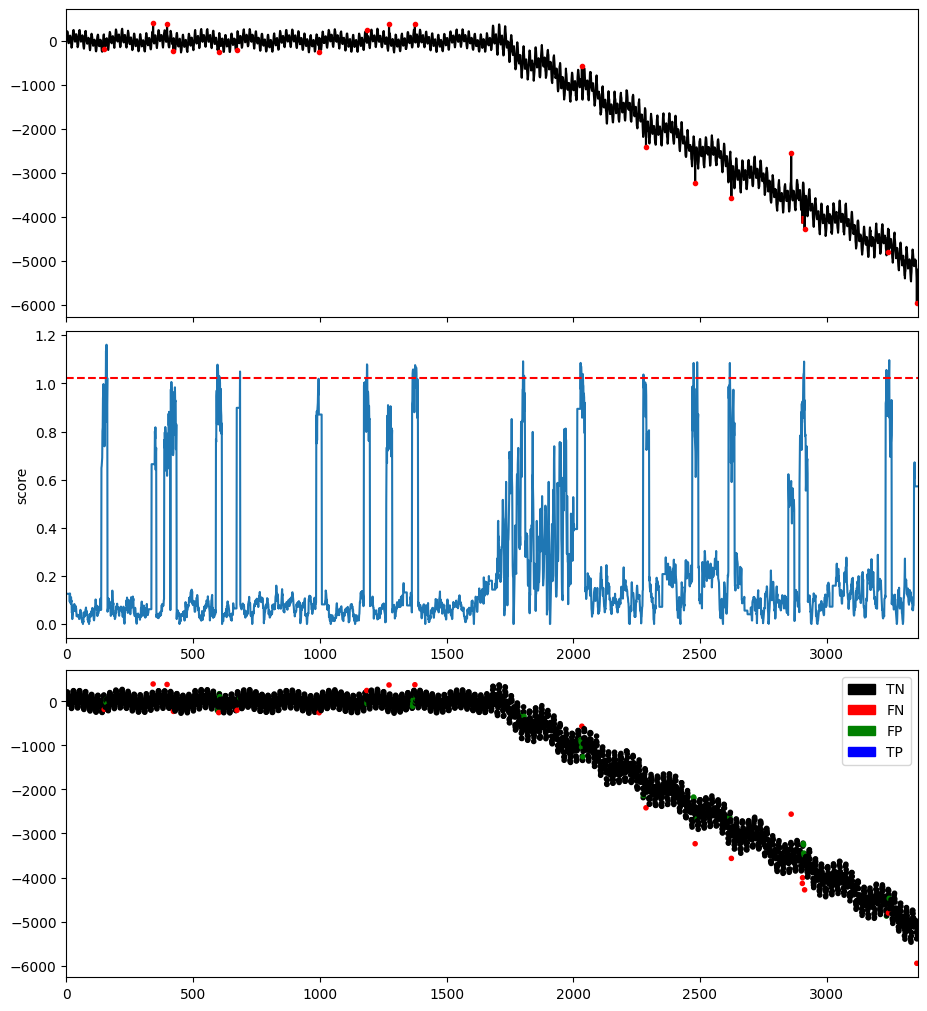

In [13]:
### Online 2 - MatrixProfile
sb_if = StreamingDetector(
batch_frac=0.1,
    overlap=1,
    n_clusters=4,
    model="matrixprofile",
    state_size=None,       
    tabpfn_device='cpu'
)
scores = sb_if.process(data)
sliding = find_length(data)
plotFig(data, label, scores, sliding, fileName='Stream_IForest', modelName='StreamIForest')
plt.show()
#plt.savefig('Stream_IForest.png', dpi=300, bbox_inches='tight')